In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pystan
import pymc3 as pm
import tensorflow as tf
import edward as ed
from edward.models import Normal, InverseGamma, Empirical

from tqdm import tqdm 
import matplotlib.pylab as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)

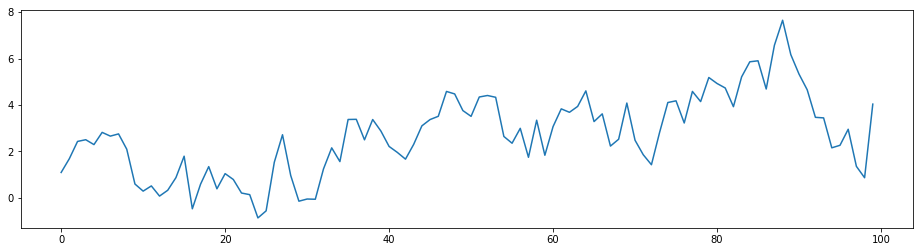

In [10]:
y = np.cumsum(np.random.normal(size=100))
plt.plot(y)

# LocalLevelの実装

## Statsmodel

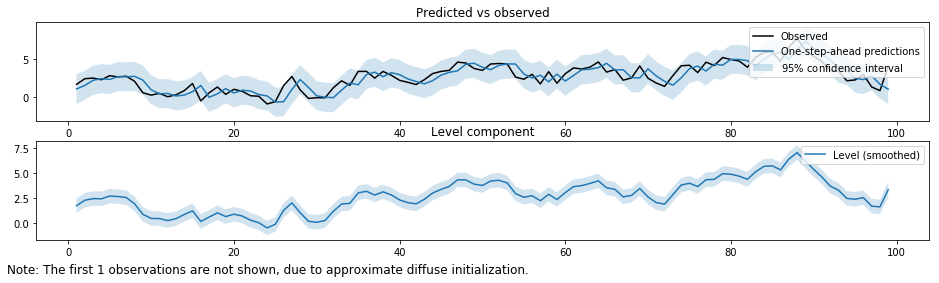

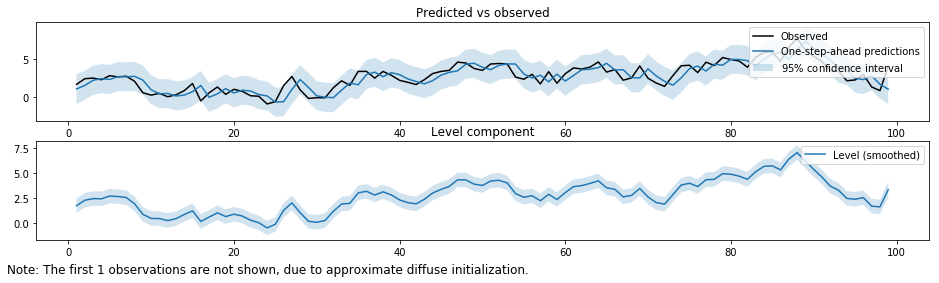

In [11]:
model = sm.tsa.UnobservedComponents(y, 'local level')
result = model.fit()
result.plot_components()

## Pystan

In [15]:
model = """
    data {
        int n; # サンプルサイズ
        vector[n] y; # 時系列の値
    }
    parameters {
        real muZero; # 左端
        vector[n] mu; # 確率的レベル
        real<lower=0> sigmaV; # 観測誤差の大きさ
        real<lower=0> sigmaW; # 過程誤差の大きさ
    }
    model {
        # 状態方程式
        mu[1] ~ normal(muZero, sqrt(sigmaW));
        for(i in 2:n) {
            mu[i] ~ normal(mu[i-1], sqrt(sigmaW));
        }
        
        # 観測方程式
        for(i in 1:n) {
            y[i] ~ normal(mu[i], sqrt(sigmaV));
        }
    }
"""
fit = pystan.stan(model_code=model, data={'n': 100, 'y': y}, iter=1000, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4eca5dff070c8e9e2e8fbdc5e7560772 NOW.
/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


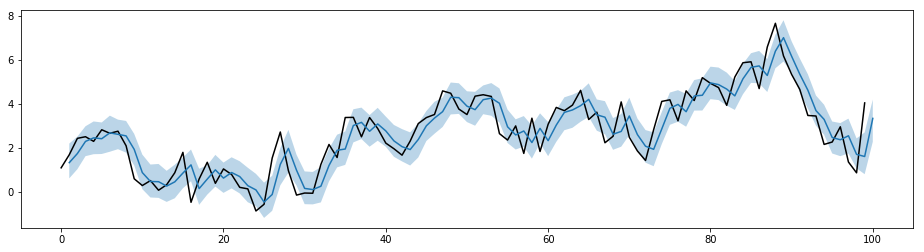

In [19]:
la = fit.extract()
 
pred = la['mu'].mean(axis=0)
mu_lower, mu_upper = np.percentile(la['mu'], q=[2.5, 97.5], axis=0)
 
plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)

## PyMC

In [26]:
N = len(y)
T = 1000
 
with pm.Model() as model:
    
    muZero = pm.Normal(name='muZero', mu=0.0, tau=1.0)
    sigmaW = pm.InverseGamma(name='sigmaW', alpha=1.0, beta=1.0)
    
    mu = [0]*N
    mu[0] = pm.Normal(name='mu0', mu=muZero, tau=1/sigmaW)
    for n in range(1, N):
        mu[n] = pm.Normal(name='mu'+str(n), mu=mu[n-1], tau=1/sigmaW)
    
    sigmaV = pm.InverseGamma(name='sigmaV', alpha=1.0, beta=1.0)
    y_pre = pm.Normal('y_pre', mu=mu, tau=1/sigmaV, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(T, step, start=start)


logp = -96.46, ||grad|| = 0.0058511: 100%|██████████| 79/79 [00:00<00:00, 265.04it/s]  
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [sigmaV_log__, mu99, mu98, mu97, mu96, mu95, mu94, mu93, mu92, mu91, mu90, mu89, mu88, mu87, mu86, mu85, mu84, mu83, mu82, mu81, mu80, mu79, mu78, mu77, mu76, mu75, mu74, mu73, mu72, mu71, mu70, mu69, mu68, mu67, mu66, mu65, mu64, mu63, mu62, mu61, mu60, mu59, mu58, mu57, mu56, mu55, mu54, mu53, mu52, mu51, mu50, mu49, mu48, mu47, mu46, mu45, mu44, mu43, mu42, mu41, mu40, mu39, mu38, mu37, mu36, mu35, mu34, mu33, mu32, mu31, mu30, mu29, mu28, mu27, mu26, mu25, mu24, mu23, mu22, mu21, mu20, mu19, mu18, mu17, mu16, mu15, mu14, mu13, mu12, mu11, mu10, mu9, mu8, mu7, mu6, mu5, mu4, mu3, mu2, mu1, mu0, sigmaW_log__, muZero]
100%|██████████| 1500/1500 [00:32<00:00, 46.60it/s]


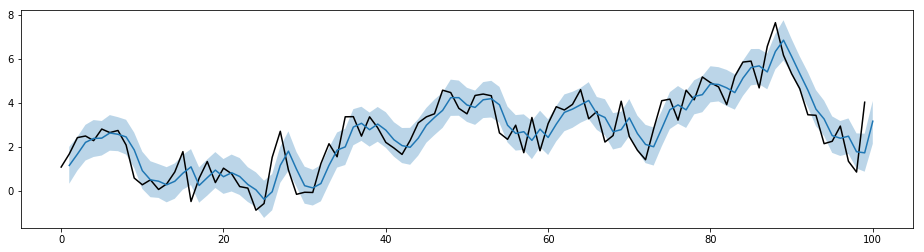

In [27]:
mu_samples = np.array([trace['mu'+str(i)] for i in range(N)])
pred = mu_samples.mean(axis=1)
mu_lower, mu_upper = np.percentile(mu_samples, q=[2.5, 97.5], axis=1)
 
plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)

## Edward

In [29]:
N = len(y)
T = 1000

muZero = Normal(loc=0.0, scale=1.0)
sigmaW = InverseGamma(concentration=1.0, rate=1.0)

mu = [0]*N
mu[0] = Normal(loc=muZero, scale=sigmaW)
for n in range(1, N):
    mu[n] = Normal(loc=mu[n-1], scale=sigmaW)

sigmaV = InverseGamma(concentration=1.0, rate=1.0)
y_pre = Normal(loc=tf.stack(mu), scale=sigmaV)

qmuZero = Empirical(tf.Variable(tf.zeros(T)))
qsigmaW = Empirical(tf.Variable(tf.zeros(T)))
qmu = [Empirical(tf.Variable(tf.zeros(T))) for n in range(N)]
qsigmaV = Empirical(tf.Variable(tf.zeros(T)))

latent_vars = {m: qm for m, qm in zip(mu, qmu)}
latent_vars[muZero] = qmuZero
latent_vars[sigmaW] = qsigmaW
latent_vars[sigmaV] = qsigmaV
inference = ed.HMC(latent_vars, data={y_pre: y})
inference.run(n_iter=T)

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 40s | Acceptance Rate: 0.000


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


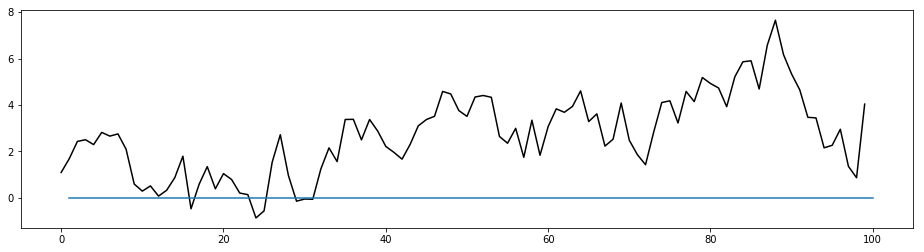

In [32]:
pred = np.zeros((len(y)), dtype=np.float32)
mu_lower = np.zeros((len(y)), dtype=np.float32)
mu_upper = np.zeros((len(y)), dtype=np.float32)
 
for i, _qmu in enumerate(tqdm(qmu)):
    
    qmu_sample = _qmu.sample(1000).eval()
    _pred = qmu_sample.mean()
    _mu_lower, _mu_upper = np.percentile(qmu_sample, q=[2.5, 97.5], axis=0)
    
    pred[i] = _pred
    mu_lower[i] = _mu_lower
    mu_upper[i] = _mu_upper
    
plt.plot(list(range(len(y)+1)), list(y)+[None], color='black')
plt.plot(list(range(1, len(y)+1)), pred)
plt.fill_between(list(range(1, len(y)+1)), mu_lower, mu_upper, alpha=0.3)